# 🎬 AI-Powered Entertainment Trendspotting with Google Trends

### Our Team Objective
Build an AI system that leverages Google Trends data to:
- Detect emerging topics in entertainment, specfically in regards to movies
- Classify their growth patterns (stable vs. emerging)
- Predict future trajectory and recommend marketing/release windows
- Provide an interface for users (e.g., movie producers) to input keywords and get actionable insights

**Outline:**
1. Setup & Data Collection
2. Data Cleaning & Feature Engineering
3. Exploratory Visualization
4. Trend Classification
5. Forecasting
6. Model Evaluation & Selection
7. Testing Model
8. Interactive Dashboard


# ~ Labeled Dataset Builder ~

This first section creates a **labeled dataset** suitable for training classification models to detect **emerging** topics.
It focuses only on **data creation & labeling** (no training).

**Pipeline**  
1. Configure seeds, timeframe, and labeling rules.  
2. Fetch Trends for each seed **plus related queries** (cohort context).  
3. Build **leakage-safe, time-indexed features** (only past data to predict the future).  
4. Create labels using a simple rule (e.g., **future 7‑day lift** > threshold).  
5. Save a single table (`CSV` + `Parquet`) for modeling.

In [ ]:
!pip -q install pytrends statsmodels pandas numpy pyarrow

In [ ]:
import os, time, math, json, random, datetime as dt
import numpy as np
import pandas as pd
from typing import List, Optional, Callable, Any

from pytrends.request import TrendReq
from statsmodels.tsa.seasonal import STL

### **0. Parameters — seeds, scope, windows, labels**

In [ ]:
# ==== INPUT KEYWORDS ===
SEED_KEYWORDS = [

    # Genres
    "romance movie", "action movie", "science fiction movie",
    "superhero movie", "horror movie", "psychological thriller",
    "mystery movie", "fantasy movie", "crime drama",
    "biographical film", "historical drama", "animated movie",
    "coming of age movie", "musical film", "family movie",

    # Themes / Topics
    "climate change movie", "ai movie", "time travel movie",
    "multiverse movie", "apocalypse movie", "zombie movie",
    "vampire movie", "robot movie", "alien invasion movie",
    "supernatural horror", "serial killer movie",
    "cyberpunk movie", "dystopian movie", "romantic comedy",
    "heist movie", "detective story", "teen romance movie",

    # Movie industry timing signals
    "movie release date", "summer blockbuster", "oscar season",
    "film festival", "movie trailer", "movie premiere", "box office",
    "movie marketing", "streaming release",

    # Character tropes
    "anti hero movie", "classic hero story", "villain origin story",
    "strong female lead", "teen protagonist", "supernatural villain",
    "chosen one trope", "mentor archetype", "love triangle",

    # Settings
    "space exploration movie", "medieval fantasy movie",
    "cyberpunk city", "post apocalyptic world", "haunted house movie",
    "island survival movie", "small town mystery",
    "new york city movie", "high school romance",

    # Narrative tropes
    "enemies to lovers", "found footage movie", "time loop movie",
    "plot twist ending", "sci fi thriller", "origin story",
    "true crime film",

    # Culture → film pipeline topics
    "urban legend", "conspiracy thriller", "cryptid sightings",
    "viral internet story", "space discoveries", "true crime stories",
    "missing person case", "reddit horror stories"
]

# ==== PYTRENDS SCOPE ===
TIMEFRAME = "today 5-y"     # e.g. 'today 12-m', 'today 5-y', 'now 7-d'
GEO       = "US"            # e.g. '' for worldwide
CATEGORY  = 23              # 0 means all categories
INCLUDE_RELATED = True
TOPN_RELATED = 5
RETRIES = 3
PAUSE   = 10.0

# ==== FEATURE WINDOWS ===
FEAT_WINDOW = 28   # short window for slope/variance/mean
REF_WINDOW  = 90   # longer baseline window for ref mean

# ==== LABELING ===
FUTURE_HORIZON = 14     # how many days ahead for the target
THRESH_LIFT   = 0.35
BINARY_LABEL  = True

# ==== OUTPUT ===
OUT_PARQUET = "labeled_trends.parquet"
OUT_CSV     = "labeled_trends.csv"
RANDOM_SEED = 13
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

### **1. Fetch trends for seeds (+ related cohort)**

In [ ]:
def with_backoff(fn: Callable, retries: int = RETRIES, pause: float = PAUSE, **kwargs) -> Any:
    """Helper to run a function with exponential backoff."""
    for i in range(retries):
        try:
            return fn(**kwargs)
        except Exception as e:
            # Handle the specific 'KeyError' which might not be a rate limit, but a data-not-found issue.
            if isinstance(e, KeyError):
                 print(f"  Data not found (KeyError): {e}. Skipping retries for this item.")
                 return None
            print(f"  Attempt {i+1}/{retries} failed: {e}")
            if i == retries - 1:
                print(f"  All {retries} attempts failed for {fn.__name__}.")
                return None # Return None on total failure
            # Exponential backoff with jitter
            sleep_time = pause * (2**i) + random.uniform(0, pause * 0.5)
            print(f"  Retrying in {sleep_time:.2f}s...")
            time.sleep(sleep_time)

# --- Modified Original Function ---
def fetch_trends_timeseries(keywords: List[str],
                             timeframe: str = TIMEFRAME,
                             geo: str = GEO,
                             category: int = CATEGORY,
                             include_related: bool = INCLUDE_RELATED,
                             topn_related: int = TOPN_RELATED,
                             pause: float = PAUSE, # Use new PAUSE default
                             retries: int = RETRIES # Use new RETRIES default
                             ) -> dict:
    """Fetch interest_over_time for a cohort: seeds + optional top/rising related queries.
    Returns dict with DataFrame at 'wide' and related_map at 'related_map'."""

    # Using 'gprop'='' for web search, as in the user's new example
    py = TrendReq(hl="en-US", tz=0)
    all_kws = list(dict.fromkeys([k.strip() for k in keywords if k]))
    related_map = {}

    if include_related:
        print("Fetching related queries...")
        for kw in all_kws:
            print(f"  - for: {kw}")
            # Use with_backoff for the payload + related_queries
            def fetch_related():
                # gprop='' for web search. cat=category
                py.build_payload([kw], timeframe=timeframe, geo=geo, cat=category, gprop='')
                return py.related_queries()

            rq = with_backoff(fetch_related, retries=retries, pause=pause)

            if rq is None:
                print(f"  Failed to get related queries for {kw}.")
                continue

            rel_tbl = rq.get(kw, {})
            rel = []
            for kind in ("top", "rising"):
                dfk = rel_tbl.get(kind)
                if dfk is not None and len(dfk):
                    rel.extend(dfk["query"].astype(str).tolist())
            rel = [r for r in rel if r.lower() != kw.lower()]
            related_map[kw] = list(dict.fromkeys(rel))[:topn_related]

            # Add a small pause even between successful keyword-related fetches
            time.sleep(pause + random.uniform(0, pause * 0.5))

        cohort = list(dict.fromkeys(all_kws + sum(related_map.values(), [])))
    else:
        cohort = all_kws

    print(f"\nFetching time series for {len(cohort)} total keywords...")

    # Fetch in batches of <= 5
    def batched(xs, n=5):
        for i in range(0, len(xs), n):
            yield xs[i:i+n]

    frames = []
    for i, grp in enumerate(batched(cohort, 5)):
        print(f"  - Batch {i+1} ({', '.join(grp)})")

        # Use with_backoff for the time series fetch
        def fetch_interest():
             # gprop='' for web search. cat=category
            py.build_payload(grp, timeframe=timeframe, geo=geo, cat=category, gprop='')
            return py.interest_over_time()

        df = with_backoff(fetch_interest, retries=retries, pause=pause)

        if df is None or df.empty:
            print("    -> No data returned for this batch.")
            continue

        if "isPartial" in df.columns:
            df = df.drop(columns=["isPartial"])
        frames.append(df)

        # Pause before the *next* request.
        time.sleep(pause + random.uniform(0, pause * 0.5))

    if not frames:
        print("No time series data was successfully fetched for any batch.")
        return {"wide": pd.DataFrame(), "related_map": related_map}

    print("Combining fetched data...")
    wide = pd.concat(frames, axis=1)
    wide = wide.loc[:, ~wide.columns.duplicated(keep="first")]
    wide = wide.loc[:, (wide != 0).any(axis=0)] # Drop cols that are all 0
    wide = wide.reset_index().rename(columns={"date": "date"})
    wide["date"] = pd.to_datetime(wide["date"])

    keep_cols = ["date"] + cohort
    wide = wide[[c for c in keep_cols if c in wide.columns]].copy()

    print(f"Fetch complete. Shape: {wide.shape}")
    return {"wide": wide, "related_map": related_map}

# --- This part remains the same, just executing the modified function ---
# Fetch once for the union of seeds
fetched = fetch_trends_timeseries(SEED_KEYWORDS)
wide = fetched["wide"]
related_map = fetched["related_map"]

# === new guard ===
if wide is None or wide.empty or ("date" not in wide.columns):
    print("ERROR: Google Trends returned no usable time series.")
    print("Check:")
    print("  - keyword spellings (Google Trends may not have them)")
    print("  - timeframe (try 'today 5-y' or 'today 3-m')")
    print("  - geo restrictions")
    display(wide)
    print("Stopping execution due to fetch error.")
else:
    print("Fetch successful. Displaying tail of the DataFrame:")
    display(wide.tail())

Fetching related queries...
  - for: romance movie
  Attempt 1/3 failed: The request failed: Google returned a response with code 429
  Retrying in 11.30s...
  Attempt 2/3 failed: The request failed: Google returned a response with code 429
  Retrying in 23.43s...
  Attempt 3/3 failed: The request failed: Google returned a response with code 429
  All 3 attempts failed for fetch_related.
  Failed to get related queries for romance movie.
  - for: action movie
  Attempt 1/3 failed: The request failed: Google returned a response with code 429
  Retrying in 13.42s...
  Attempt 2/3 failed: The request failed: Google returned a response with code 429
  Retrying in 24.25s...
  - for: science fiction movie
  - for: superhero movie
  - for: horror movie
  - for: psychological thriller
  - for: mystery movie
  - for: fantasy movie
  - for: crime drama
  - for: biographical film
  - for: historical drama
  - for: animated movie
  - for: coming of age movie
  - for: musical film
  - for: family m

/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  - Batch 2 (psychological thriller, mystery movie, fantasy movie, crime drama, biographical film)


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  - Batch 3 (historical drama, animated movie, coming of age movie, musical film, family movie)


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  - Batch 4 (climate change movie, ai movie, time travel movie, multiverse movie, apocalypse movie)


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  - Batch 5 (zombie movie, vampire movie, robot movie, alien invasion movie, supernatural horror)


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  - Batch 6 (serial killer movie, cyberpunk movie, dystopian movie, romantic comedy, heist movie)


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  - Batch 7 (detective story, teen romance movie, movie release date, summer blockbuster, oscar season)


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  - Batch 8 (film festival, movie trailer, movie premiere, box office, movie marketing)


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  - Batch 9 (streaming release, anti hero movie, classic hero story, villain origin story, strong female lead)


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  - Batch 10 (teen protagonist, supernatural villain, chosen one trope, mentor archetype, love triangle)


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  - Batch 11 (space exploration movie, medieval fantasy movie, cyberpunk city, post apocalyptic world, haunted house movie)


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  - Batch 12 (island survival movie, small town mystery, new york city movie, high school romance, enemies to lovers)


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  - Batch 13 (found footage movie, time loop movie, plot twist ending, sci fi thriller, origin story)


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  - Batch 14 (true crime film, urban legend, conspiracy thriller, cryptid sightings, viral internet story)
    -> No data returned for this batch.
  - Batch 15 (space discoveries, true crime stories, missing person case, reddit horror stories, action movies)


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  - Batch 16 (wicked live action movie, back in action, who plays cinderella in the live action movie, rocky horror movie, rocky horror picture show)


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  - Batch 17 (ventriloquist horror movie, horror movies, horror movie monologues, murder mystery movie, mystery movies)


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  - Batch 18 (murder mystery movies, new murder mystery movie, murder mystery movie 2022, historical drama movies, lord of the rings animated movie)


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  - Batch 19 (the lord of the rings animated movie, nutcracker animated movie, a christmas carol animated movie, lord of the rings animated movie 2024, wicked musical film)


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  - Batch 20 (rent musical film, cats musical film, les miserables musical film, hair musical film, family movies)


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  - Batch 21 (addams family movie, the addams family movie, family movie night, vampire movies, johnny depp vampire movie)


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  - Batch 22 (philip ridley vampire movie, tom hiddleston vampire movie, wild robot movie, wild robot, the wild robot movie)


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  - Batch 23 (the wild robot, robin williams robot movie, my teen romantic comedy, romantic comedy movies, romantic comedy definition)


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  - Batch 24 (the heist movie, heist movies, tower heist, wicked movie, wicked 2 movie release date)


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  - Batch 25 (wicked the movie release date, in the heights movie release date, mean girls' musical movie release date, tribeca film festival, new york film festival)


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  - Batch 26 (dance film festival, jewish film festival, sundance film festival, movies, wicked the movie trailer)


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  - Batch 27 (wicked movie trailer 2024, phantom of the opera movie trailer, in the heights movie trailer, wicked premiere, wicked movie premiere)


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  - Batch 28 (wicked box office, broadway box office, little mermaid box office, the little mermaid box office, jurassic world box office)


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  - Batch 29 (wicked streaming release, west side story streaming release date, west side story 2021 streaming release date, in the heights streaming release date, see how they run streaming release date)


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  - Batch 30 (olivia rodrigo love triangle, twelfth night love triangle, love triangle in twelfth night, what is a love triangle, wicked love triangle)


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  - Batch 31 (enemies to lovers books, enemies to lovers trope, enemies to lovers movies)


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


Combining fetched data...
Fetch complete. Shape: (262, 105)
Fetch successful. Displaying tail of the DataFrame:


,date,romance movie,action movie,science fiction movie,superhero movie,horror movie,psychological thriller,mystery movie,fantasy movie,crime drama,...,wicked box office,broadway box office,little mermaid box office,the little mermaid box office,jurassic world box office,wicked streaming release,west side story streaming release date,in the heights streaming release date,love triangle in twelfth night,enemies to lovers trope
257,2025-10-26,0,0,0,0,50,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
258,2025-11-02,0,0,0,0,0,0,74,0,86,...,1,1,0,0,0,0,0,0,100,0
259,2025-11-09,4,7,0,0,19,0,24,6,0,...,2,1,0,0,0,0,0,0,0,0
260,2025-11-16,7,17,0,0,22,0,26,4,4,...,10,1,0,0,0,13,0,0,0,0
261,2025-11-23,0,0,0,0,34,0,0,0,0,...,51,2,0,0,0,0,0,0,0,0


### **2. Leakage-safe feature builder**
We compute features at each time **t** using only data up to **t** (no future).

In [ ]:
# ------------ helper functions ------------

def _ols_slope(arr: np.ndarray,
               min_len: int = 3,
               eps: float = 1e-9) -> float:
    """
    Robust slope of a 1D array using OLS on index vs value.

    - Returns NaN if there are fewer than min_len points.
    - Returns 0.0 if the window is (almost) flat (very small variance).
    """
    arr = np.asarray(arr, dtype=float)
    # Drop non-finite values if any
    arr = arr[np.isfinite(arr)]
    n = arr.size
    if n < min_len:
        return np.nan

    # x = 0,1,2,...,n-1
    x = np.arange(n, dtype=float)

    # center x and y to improve numerical stability
    y = arr - arr.mean()
    x = x - x.mean()

    # If y has almost no variance, treat as flat
    var_y = (y ** 2).mean()
    if var_y < eps:
        return 0.0

    denom = (x ** 2).sum()
    if denom < eps:
        return 0.0

    slope = (x * y).sum() / denom
    return float(slope)



def _zscore_last(arr: np.ndarray) -> float:
    if len(arr) < 3:
        return np.nan
    mu = np.mean(arr[:-1])
    sd = np.std(arr[:-1]) + 1e-9
    return float((arr[-1] - mu) / sd)


def _days_since_peak(series: pd.Series) -> float:
    if series.isna().all():
        return np.nan
    idx = int(series.values.argmax())
    return float(len(series) - 1 - idx)


def _gini(arr: np.ndarray) -> float:
    arr = np.asarray(arr, dtype=float)
    if np.all(arr == 0):
        return 0.0
    if np.amin(arr) < 0:
        arr -= np.amin(arr)
    arr += 1e-9
    arr.sort()
    n = arr.size
    cum = np.cumsum(arr)
    return float((n + 1 - 2 * np.sum(cum) / cum[-1]) / n)


def _stl_strength(y: np.ndarray, period: int = 7):
    try:
        stl = STL(y, period=period, robust=True)
        res = stl.fit()
        resid_var = np.var(res.resid)
        trend_var = np.var(res.trend)
        seas_var  = np.var(res.seasonal)
        trend_strength = trend_var / (trend_var + resid_var + 1e-9)
        seas_strength  = seas_var  / (seas_var  + resid_var + 1e-9)
        return float(trend_strength), float(seas_strength)
    except Exception:
        return np.nan, np.nan


# ------------ main feature builder ------------

def build_time_indexed_features(
    wide: pd.DataFrame,
    keyword: str,
    cohort_cols: Optional[List[str]] = None,
    feat_window: int = FEAT_WINDOW,
    ref_window: int = REF_WINDOW,
    stl_period: int = 7,
    future_horizon: int = FUTURE_HORIZON,
) -> pd.DataFrame:
    """
    Build time-indexed, leakage-safe features for a single keyword.

    For each time t:
      - features use history up to and including t
      - label targets use t+1 .. t+future_horizon
    """
    df = wide.dropna(subset=["date"]).sort_values("date").reset_index(drop=True)
    if keyword not in df.columns:
        return pd.DataFrame()

    if cohort_cols is None:
        cohort_cols = [c for c in df.columns if c not in ["date", keyword]]

    out_rows = []

    for i in range(len(df)):
        # need enough history (for windows + STL) and enough future for the label
        if i < max(5, feat_window // 3, stl_period * 3):
            continue
        if i + future_horizon >= len(df):
            break

        hist = df.iloc[: i + 1].copy()
        fut  = df.iloc[i + 1 : i + 1 + future_horizon].copy()

        ts = hist[keyword].astype(float).fillna(0.0)
        last = float(ts.iloc[-1])

        # --- rolling windows for short-term stats ---
        roll = ts.rolling(feat_window, min_periods=max(5, feat_window // 3))
        mean_w_series = roll.mean()
        std_w_series  = roll.std()
        med_w_series  = roll.median()

        mean_w_val = float(mean_w_series.iloc[-1]) if not np.isnan(mean_w_series.iloc[-1]) else np.nan
        std_w_val  = float(std_w_series.iloc[-1])  if not np.isnan(std_w_series.iloc[-1])  else np.nan
        med_w_val  = float(med_w_series.iloc[-1])  if not np.isnan(med_w_series.iloc[-1])  else np.nan

        # --- longer reference window ---
        ref_series = ts.rolling(ref_window, min_periods=max(7, ref_window // 4)).mean()
        ref_val = float(ref_series.iloc[-1]) if not np.isnan(ref_series.iloc[-1]) else np.nan

        # --- slope and z-score ---
        slope = _ols_slope(ts.iloc[-feat_window:].values) if len(ts) >= feat_window else np.nan
        z_last = _zscore_last(ts.values)

        # --- lifts & basic dynamics ---
        if not np.isnan(mean_w_val) and mean_w_val != 0:
            lift_vs_mean = (last - mean_w_val) / (mean_w_val + 1e-9)
        else:
            lift_vs_mean = np.nan

        if not np.isnan(ref_val) and ref_val != 0:
            lift_vs_ref = (last - ref_val) / (ref_val + 1e-9)
        else:
            lift_vs_ref = np.nan

        momentum_1 = float(ts.diff(1).iloc[-1]) if len(ts) >= 2 else np.nan
        momentum_7 = float(ts.diff(7).iloc[-1]) if len(ts) >= 8 else np.nan

        coefvar = (
            float(std_w_val / (mean_w_val + 1e-9))
            if not np.isnan(mean_w_val)
            else np.nan
        )

        # --- shape / burstiness stats ---
        dsp        = _days_since_peak(ts)
        peak       = float(ts.max())
        peak_gini  = _gini(ts.values)
        if ts.notna().any():
            q75, q25 = np.percentile(ts.values, [75, 25])
        else:
            q75, q25 = np.nan, np.nan
        iqr = float(q75 - q25) if not (np.isnan(q75) or np.isnan(q25)) else np.nan
        burstiness = (
            iqr / (med_w_val + 1e-9)
            if not np.isnan(iqr) and not np.isnan(med_w_val)
            else np.nan
        )

        # --- STL-based trend/seasonality strength ---
        t_strength, s_strength = _stl_strength(ts.values, period=stl_period)

        row = {
            "date": hist["date"].iloc[-1],
            "keyword": keyword,
            "level_last": last,
            "mean_w": mean_w_val,            # <- used by add_labels
            "slope_w": slope,
            "z_last": z_last,
            "lift_vs_mean_w": lift_vs_mean,
            "lift_vs_ref": lift_vs_ref,
            "momentum_1": momentum_1,
            "momentum_7": momentum_7,
            "coefvar_w": coefvar,
            "days_since_peak": dsp,
            "peak": peak,
            "peak_gini": peak_gini,
            "burstiness": burstiness,
            "trend_strength": t_strength,
            "seasonality_strength": s_strength,
        }

        # --- cohort features, if any ---
        if cohort_cols:
            cohort_hist = hist[cohort_cols].astype(float).fillna(0.0)
            cohort_med_series = cohort_hist.median(axis=1)
            cohort_last_med = float(cohort_med_series.iloc[-1])

            if cohort_last_med != 0:
                row["lift_vs_cohort_med"] = (last - cohort_last_med) / (cohort_last_med + 1e-9)
            else:
                row["lift_vs_cohort_med"] = np.nan

            ys = (
                cohort_med_series.iloc[-feat_window:].values
                if len(cohort_med_series) >= feat_window
                else cohort_med_series.values
            )
            xs = ts.iloc[-len(ys):].values

            if (
                len(xs) > 3
                and len(ys) > 3
                and np.std(xs) > 1e-9
                and np.std(ys) > 1e-9
            ):
                row["corr_with_cohort_med"] = float(np.corrcoef(xs, ys)[0, 1])
            else:
                row["corr_with_cohort_med"] = np.nan
        else:
            row["lift_vs_cohort_med"] = np.nan
            row["corr_with_cohort_med"] = np.nan

        # --- FUTURE window (for labels) ---
        fut_vals = fut[keyword].astype(float).values
        row["future_mean_7d"] = float(np.mean(fut_vals))
        row["future_max_7d"]  = float(np.max(fut_vals))
        row["future_sum_7d"]  = float(np.sum(fut_vals))

        out_rows.append(row)

    return pd.DataFrame(out_rows)


# ------------ build features for all seed keywords ------------

all_rows = []
for seed in SEED_KEYWORDS:
    cohort_cols = [c for c in wide.columns if c not in ["date", seed]]
    feats = build_time_indexed_features(wide, seed, cohort_cols=cohort_cols)
    if not feats.empty:
        all_rows.append(feats)

features_df = pd.concat(all_rows, ignore_index=True) if all_rows else pd.DataFrame()
features_df.head()


,date,keyword,level_last,mean_w,slope_w,z_last,lift_vs_mean_w,lift_vs_ref,momentum_1,momentum_7,...,peak,peak_gini,burstiness,trend_strength,seasonality_strength,lift_vs_cohort_med,corr_with_cohort_med,future_mean_7d,future_max_7d,future_sum_7d
0,2021-04-18,romance movie,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
1,2021-04-25,romance movie,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
2,2021-05-02,romance movie,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
3,2021-05-09,romance movie,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
4,2021-05-16,romance movie,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0


In [ ]:
features_df.head(25)

,date,keyword,level_last,mean_w,slope_w,z_last,lift_vs_mean_w,lift_vs_ref,momentum_1,momentum_7,...,peak,peak_gini,burstiness,trend_strength,seasonality_strength,lift_vs_cohort_med,corr_with_cohort_med,future_mean_7d,future_max_7d,future_sum_7d
0,2021-04-18,romance movie,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
1,2021-04-25,romance movie,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
2,2021-05-02,romance movie,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
3,2021-05-09,romance movie,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
4,2021-05-16,romance movie,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
5,2021-05-23,romance movie,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
6,2021-05-30,romance movie,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
7,2021-06-06,romance movie,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
8,2021-06-13,romance movie,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
9,2021-06-20,romance movie,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0


### **3. Label creation**
Default: **binary 'Emerging'** if `future_mean_7d` shows ≥35% lift over current short-window mean.

In [ ]:
def add_labels(df: pd.DataFrame,
               binary: bool = BINARY_LABEL,
               thresh_lift: float = THRESH_LIFT) -> pd.DataFrame:
    """
    Creates ground-truth labels for training/validation,
    based only on leakage-safe "future_mean_7d".

    If binary=True:
        1 => emerging (future_mean_7d >= mean(last_window) * (1 + thresh_lift))
        0 => not emerging

    If binary=False:
        0 => stable_or_low
        1 => rising
        2 => emerging
    """
    df = df.copy()

    mean_window = df.get("mean_w", (df["level_last"] / (1 + df["lift_vs_mean_w"].fillna(-1.0))))

    # guard against division by zero
    denom = (mean_window + 1e-9)

    # growth ratio used for labeling
    growth = (df["future_mean_7d"] - mean_window) / denom
    df["growth_label_metric"] = growth

    if binary:
        # True/False → 1/0
        df["target"] = (growth >= thresh_lift).astype(int)
    else:
        # 3-class labeling based on quantiles
        # compute quantiles using only valid numeric values
        q1, q2 = growth.quantile([0.33, 0.66])

        def bucket(g):
            if pd.isna(g):
                return np.nan
            if g <= q1:
                return 0
            if g <= q2:
                return 1
            return 2

        df["target"] = growth.apply(bucket)

    return df
labeled = add_labels(features_df)
labeled.head()

,date,keyword,level_last,mean_w,slope_w,z_last,lift_vs_mean_w,lift_vs_ref,momentum_1,momentum_7,...,burstiness,trend_strength,seasonality_strength,lift_vs_cohort_med,corr_with_cohort_med,future_mean_7d,future_max_7d,future_sum_7d,growth_label_metric,target
0,2021-04-18,romance movie,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0
1,2021-04-25,romance movie,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0
2,2021-05-02,romance movie,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0
3,2021-05-09,romance movie,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0
4,2021-05-16,romance movie,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0


### **4. Quality checks — class balance & missing values**

In [ ]:
print("Rows:", len(labeled))
print("Date range:", labeled["date"].min(), "->", labeled["date"].max())
print("\nClass distribution:")
print(labeled["target"].value_counts(dropna=False).sort_index())

missing = labeled.isna().mean().sort_values(ascending=False)
print("\nColumns with >10% missing:")
print(missing[missing > 0.10].head(20))


Rows: 10896
Date range: 2021-04-18 00:00:00 -> 2025-08-17 00:00:00

Class distribution:
target
0    9371
1    1525
Name: count, dtype: int64

Columns with >10% missing:
lift_vs_cohort_med      1.000000
corr_with_cohort_med    1.000000
lift_vs_mean_w          0.700899
lift_vs_ref             0.512482
dtype: float64


### **5. Save artifacts**

In [ ]:
labeled.to_parquet("{OUT_PARQUET}", index=False)
labeled.to_csv("{OUT_CSV}", index=False)
print("Saved:", OUT_PARQUET, "and", OUT_CSV)

Saved: labeled_trends.parquet and labeled_trends.csv


# ~ Model Creation and Selection ~

This next section trains and creates multiple models by using a **labeled dataset** that was created from the **first portion above**. The specific data set used is the **labeled_trends.csv** file; this data was utilized to train the model.

## 📋 Workflow Overview

This notebook follows these key steps:

1. **Data Upload & Setup** - Upload the labeled trends dataset and install required packages
2. **Configuration** - Define model hyperparameters and preprocessing settings
3. **Data Loading & Exploration** - Load data and examine class distribution
4. **Feature Engineering** - Select features and handle missing values
5. **Train/Test Split** - Create time-based split to prevent data leakage
6. **Preprocessing** - Impute missing values, scale features, handle class imbalance
7. **Model Training** - Train 5 different models (XGBoost, LightGBM, Random Forest, Gradient Boosting, Logistic Regression)
8. **Model Evaluation** - Compare models using multiple metrics (Accuracy, Precision, Recall, F1, ROC-AUC)
9. **Visualization** - Generate confusion matrices, ROC curves, PR curves, and feature importance plots
10. **Model Selection** - Identify the best performing model for predicting emerging movie trends

## 🎯 Goal

Predict which movie-related topics will become **emerging trends** in the next 7-14 days based on historical Google Trends data.

---

### **Step 1: Data Upload & Environment Setup**

In this section, we:
- **Upload the labeled dataset** (`labeled_trends.csv` or `.parquet`) created from the previous notebook
- **Install required Python packages** for machine learning, data manipulation, and visualization

### Required Packages:
- `xgboost` & `lightgbm` - Advanced gradient boosting frameworks
- `scikit-learn` - Core ML library with preprocessing, models, and evaluation metrics
- `pandas` & `numpy` - Data manipulation and numerical operations
- `matplotlib` & `seaborn` - Visualization libraries
- `imbalanced-learn` - Tools for handling class imbalance

**⚠️ Action Required:** When prompted, upload your `labeled_trends.csv` or `labeled_trends.parquet` file.

---

In [ ]:
# Upload your labeled_trends.csv file
from google.colab import files
import os

print("Please upload your labeled_trends.csv file:")
uploaded = files.upload()

# Get the filename
DATA_PATH = list(uploaded.keys())[0]
print(f"✓ Uploaded: {DATA_PATH}")

# Install required packages
print("\nInstalling packages...")
!pip -q install xgboost lightgbm scikit-learn pandas numpy matplotlib seaborn imbalanced-learn
print("✓ Packages installed")

Please upload your labeled_trends.csv file:


Saving labeled_trends.csv to labeled_trends (1).csv
✓ Uploaded: labeled_trends (1).csv

Installing packages...
✓ Packages installed


### **Step 2: Imports & Configuration**

In this section, we:
- **Import all necessary libraries** for machine learning and data processing
- **Define configuration parameters** that control our training pipeline
- **Set hyperparameters** for each model we'll train

### Key Configuration Decisions:

#### Class Imbalance Handling
Our dataset likely has many more "not emerging" examples than "emerging" examples. We handle this using:
- **`class_weight='balanced'`** - Makes the model penalize errors on the minority class more heavily

#### Time-Based Validation
- **Hold out last 6 months** for testing to simulate real-world deployment
- This prevents "future leakage" where models cheat by seeing future data during training

#### Feature Preprocessing
- **Imputation:** Fill missing values with median
- **Scaling:** Normalize features to mean=0, std=1 (helps Logistic Regression especially)

### Models We'll Train:
1. **XGBoost** - Usually top performer, sequential tree building
2. **LightGBM** - Fast alternative to XGBoost, histogram-based learning
3. **Random Forest** - Ensemble of independent trees, good baseline
4. **Gradient Boosting** - sklearn's implementation, sometimes more stable
5. **Logistic Regression** - Linear baseline to test if problem is linearly separable

---

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Model evaluation
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve, precision_recall_curve,
    f1_score, accuracy_score, precision_score, recall_score,
    average_precision_score
)

# Feature processing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# ===== CONFIGURATION =====
TEST_SIZE_MONTHS = 6
HANDLE_IMBALANCE = True
IMBALANCE_METHOD = "class_weight"
SCALE_FEATURES = True
IMPUTE_STRATEGY = "median"
RANDOM_STATE = 42
N_JOBS = -1

# Model hyperparameters
XGB_PARAMS = {
    'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.05,
    'subsample': 0.8, 'colsample_bytree': 0.8, 'random_state': RANDOM_STATE,
    'n_jobs': N_JOBS, 'eval_metric': 'logloss'
}

LGBM_PARAMS = {
    'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.05,
    'subsample': 0.8, 'colsample_bytree': 0.8, 'random_state': RANDOM_STATE,
    'n_jobs': N_JOBS, 'verbose': -1
}

RF_PARAMS = {
    'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 10,
    'min_samples_leaf': 5, 'random_state': RANDOM_STATE, 'n_jobs': N_JOBS
}

GB_PARAMS = {
    'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05,
    'subsample': 0.8, 'random_state': RANDOM_STATE
}

LR_PARAMS = {
    'max_iter': 1000, 'random_state': RANDOM_STATE, 'n_jobs': N_JOBS
}

print("✓ All imports and configuration loaded")

✓ All imports and configuration loaded


### **Step 3: Data Loading & Preprocessing**

In this section, we:
- **Load the labeled dataset** and convert dates to proper format
- **Define feature columns** by excluding metadata, target, and future-looking variables
- **Create time-based train/test split** (last 6 months held out for testing)
- **Handle missing values** using median imputation
- **Scale features** to normalize magnitudes
- **Apply class weights** to handle imbalanced classes

### Critical: Preventing Data Leakage

We use **time-based splitting** instead of random splitting:
- ✅ **Training data:** All data before the cutoff date
- ✅ **Test data:** Most recent 6 months

This simulates real-world deployment where we:
1. Train on historical data
2. Predict future trends we haven't seen yet

### Feature Selection

We exclude these columns to prevent leakage:
- `date`, `keyword` - Metadata, not predictive features
- `target` - What we're trying to predict
- `growth_label_metric` - Used to create the target (would leak information)
- `future_mean_7d`, `future_max_7d`, `future_sum_7d` - Future data (cheating!)

**Check the additional file added titled Design Documentation to get further explination on why these features were excluded.**

---

In [ ]:
# ===== LOAD DATA =====
if DATA_PATH.endswith('.parquet'):
    df = pd.read_parquet(DATA_PATH)
else:
    df = pd.read_csv(DATA_PATH)

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

print(f"Loaded {len(df):,} rows from {df['date'].min().date()} to {df['date'].max().date()}")
print(f"\nTarget distribution:\n{df['target'].value_counts()}")
print(f"\nClass balance:\n{df['target'].value_counts(normalize=True).round(3)}")

Loaded 13,393 rows from 2021-04-11 to 2025-08-10

Target distribution:
target
0    11596
1     1797
Name: count, dtype: int64

Class balance:
target
0    0.866
1    0.134
Name: proportion, dtype: float64


In [ ]:
# ===== DEFINE FEATURES =====
EXCLUDE_COLS = ['date', 'keyword', 'target', 'growth_label_metric',
                'future_mean_7d', 'future_max_7d', 'future_sum_7d']
feature_cols = [col for col in df.columns if col not in EXCLUDE_COLS]

# Remove columns that are all NaN or non-numeric
numeric_cols = df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
valid_cols = [col for col in numeric_cols if df[col].notna().sum() > 0]

print(f"\n✓ Using {len(valid_cols)} numeric features (removed {len(feature_cols) - len(valid_cols)} invalid columns)")
feature_cols = valid_cols



✓ Using 15 numeric features (removed 2 invalid columns)


In [ ]:
# ===== TRAIN/TEST SPLIT (TIME-BASED) =====
test_cutoff_date = df['date'].max() - pd.DateOffset(months=TEST_SIZE_MONTHS)
train_mask = df['date'] < test_cutoff_date
test_mask = df['date'] >= test_cutoff_date

X_train_raw = df[train_mask][feature_cols]
y_train = df[train_mask]['target']
X_test_raw = df[test_mask][feature_cols]
y_test = df[test_mask]['target']

print(f"\nTrain set: {len(X_train_raw):,} rows")
print(f"Test set:  {len(X_test_raw):,} rows")



Train set: 11,859 rows
Test set:  1,534 rows


In [ ]:
# ===== PREPROCESSING =====
# Impute missing values
imputer = SimpleImputer(strategy=IMPUTE_STRATEGY)
X_train_imputed = imputer.fit_transform(X_train_raw)
X_test_imputed = imputer.transform(X_test_raw)

# Get feature names that survived imputation
feature_cols_after_impute = feature_cols.copy()

# Convert back to DataFrames with correct column names
X_train_imputed = pd.DataFrame(
    X_train_imputed,
    columns=feature_cols_after_impute,
    index=X_train_raw.index
)
X_test_imputed = pd.DataFrame(
    X_test_imputed,
    columns=feature_cols_after_impute,
    index=X_test_raw.index
)



In [ ]:
# Scale features
if SCALE_FEATURES:
    scaler = StandardScaler()
    X_train = pd.DataFrame(
        scaler.fit_transform(X_train_imputed),
        columns=feature_cols_after_impute,
        index=X_train_imputed.index
    )
    X_test = pd.DataFrame(
        scaler.transform(X_test_imputed),
        columns=feature_cols_after_impute,
        index=X_test_imputed.index
    )
else:
    X_train = X_train_imputed
    X_test = X_test_imputed

# Update feature_cols to match what we actually have
feature_cols = feature_cols_after_impute

print(f"\n✓ Final feature count: {len(feature_cols)}")


✓ Final feature count: 15


In [ ]:
# ===== HANDLE CLASS IMBALANCE =====
if HANDLE_IMBALANCE and IMBALANCE_METHOD == "class_weight":
    classes = np.unique(y_train)
    weights = compute_class_weight('balanced', classes=classes, y=y_train)
    class_weights = dict(zip(classes, weights))
    print(f"\n✓ Using class weights: {class_weights}")
elif HANDLE_IMBALANCE and IMBALANCE_METHOD == "smote":
    from imblearn.over_sampling import SMOTE
    smote = SMOTE(random_state=RANDOM_STATE)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    print(f"\n✓ Applied SMOTE. New size: {len(X_train):,}")
    class_weights = None
else:
    class_weights = None

print("\n✓ Preprocessing complete")
print(f"Final shape - Train: {X_train.shape}, Test: {X_test.shape}")


✓ Using class weights: {np.int64(0): np.float64(0.5812665424958338), np.int64(1): np.float64(3.5762967430639323)}

✓ Preprocessing complete
Final shape - Train: (11859, 15), Test: (1534, 15)


### **Step 4: Model Training**

In this section, we:
- **Initialize 5 different model types** with optimized hyperparameters
- **Train each model** on the training data
- **Track training time** for each model
- **Generate predictions** on the held-out test set

### Why Multiple Models?

Different models have different strengths:
- **Tree-based models** (XGBoost, LightGBM, RF, GB) - Good at capturing non-linear relationships and interactions
- **Linear models** (Logistic Regression) - Fast, interpretable baseline

### Training Process

For each model:
1. Initialize with pre-configured hyperparameters
2. Apply class weights (if using class_weight method)
3. Fit to training data
4. Measure training time
5. Generate both:
   - **Binary predictions** (0 or 1)
   - **Probability scores** (0.0 to 1.0) - needed for ROC/PR curves


---

In [ ]:
# ===== DEFINE MODELS =====
models = {}

# XGBoost
if class_weights and IMBALANCE_METHOD == "class_weight":
    XGB_PARAMS['scale_pos_weight'] = class_weights[1] / class_weights[0]
models['XGBoost'] = XGBClassifier(**XGB_PARAMS)

# LightGBM
if class_weights and IMBALANCE_METHOD == "class_weight":
    LGBM_PARAMS['class_weight'] = class_weights
models['LightGBM'] = LGBMClassifier(**LGBM_PARAMS)

# Random Forest
if class_weights and IMBALANCE_METHOD == "class_weight":
    RF_PARAMS['class_weight'] = class_weights
models['Random Forest'] = RandomForestClassifier(**RF_PARAMS)

# Gradient Boosting
models['Gradient Boosting'] = GradientBoostingClassifier(**GB_PARAMS)

# Logistic Regression
if class_weights and IMBALANCE_METHOD == "class_weight":
    LR_PARAMS['class_weight'] = class_weights
models['Logistic Regression'] = LogisticRegression(**LR_PARAMS)

print(f"✓ Defined {len(models)} models")


✓ Defined 5 models


In [ ]:
# ===== TRAIN ALL MODELS =====
trained_models = {}
training_times = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    start_time = datetime.now()

    if name == 'Gradient Boosting' and class_weights:
        sample_weights = np.array([class_weights[y] for y in y_train])
        model.fit(X_train, y_train, sample_weight=sample_weights)
    else:
        model.fit(X_train, y_train)

    elapsed = (datetime.now() - start_time).total_seconds()
    training_times[name] = elapsed
    trained_models[name] = model
    print(f"  ✓ Trained in {elapsed:.2f} seconds")



Training XGBoost...
  ✓ Trained in 1.98 seconds

Training LightGBM...
  ✓ Trained in 2.05 seconds

Training Random Forest...
  ✓ Trained in 4.76 seconds

Training Gradient Boosting...
  ✓ Trained in 13.42 seconds

Training Logistic Regression...
  ✓ Trained in 5.21 seconds


In [ ]:
# ===== GENERATE PREDICTIONS =====
predictions = {}
probabilities = {}

# Adjustable threshold for classification
# Default is 0.5, but lowering it can catch more emerging trends
# Lower threshold = Higher recall (catch more trends) but lower precision (more false alarms)
THRESHOLD = 0.35  # Experiment with values between 0.3 and 0.5

print(f"\nUsing classification threshold: {THRESHOLD}")
print("(Probabilities >= {:.2f} will be classified as 'emerging')".format(THRESHOLD))

for name, model in trained_models.items():
    # Get probability scores for the positive class (emerging = 1)
    probs = model.predict_proba(X_test)[:, 1]

    # Apply custom threshold instead of default 0.5
    predictions[name] = (probs >= THRESHOLD).astype(int)

    # Store probabilities for ROC/PR curves
    probabilities[name] = probs

print("\n✓ All models trained and predictions generated with custom threshold")


Using classification threshold: 0.35
(Probabilities >= 0.35 will be classified as 'emerging')

✓ All models trained and predictions generated with custom threshold


In [ ]:
# ===== CREATE SIMPLE ENSEMBLE =====
print("\n" + "="*80)
print("CREATING ENSEMBLE MODEL")
print("="*80)

# Average probabilities from XGBoost and LightGBM (usually best 2)
ensemble_probs = (probabilities['XGBoost'] + probabilities['LightGBM']) / 2

# Apply threshold
ensemble_preds = (ensemble_probs >= THRESHOLD).astype(int)

# Add to dictionaries
predictions['Ensemble (XGB+LGBM)'] = ensemble_preds
probabilities['Ensemble (XGB+LGBM)'] = ensemble_probs
trained_models['Ensemble (XGB+LGBM)'] = None

print("✓ Ensemble created: XGBoost + LightGBM")
print("="*80)


CREATING ENSEMBLE MODEL
✓ Ensemble created: XGBoost + LightGBM


### **Step 5: Model Evaluation & Metrics Comparison**

In this section, we:
- **Calculate performance metrics** for each model
- **Create comparison visualizations** to see which model performs best
- **Analyze confusion matrices** to understand error types

### Key Metrics Explained:

| Metric | What It Measures | When It's Important |
|--------|------------------|---------------------|
| **Accuracy** | Overall correctness | Balanced datasets only |
| **Precision** | Of predicted "emerging", how many actually emerge? | When false alarms are costly |
| **Recall** | Of actual emerging trends, how many did we catch? | When missing trends is costly |
| **F1 Score** | Harmonic mean of precision & recall | Balanced performance |
| **ROC-AUC** | Ability to discriminate between classes | Overall model quality |
| **Avg Precision** | Area under PR curve | Imbalanced datasets |

### Confusion Matrix Components:

- **True Positives (TP):** Correctly predicted emerging trends
- **True Negatives (TN):** Correctly predicted non-emerging
- **False Positives (FP):** Predicted emerging, but wasn't (false alarm)
- **False Negatives (FN):** Missed an emerging trend (worst case!)

---

In [ ]:
# ===== CALCULATE METRICS =====
results = []

for name in trained_models.keys():
    y_pred = predictions[name]
    y_prob = probabilities[name]

    # Get training time, defaulting to np.nan for models without a recorded training time (e.g., ensemble)
    train_time = training_times.get(name, np.nan)

    result = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1': f1_score(y_test, y_pred, zero_division=0),
        'ROC-AUC': roc_auc_score(y_test, y_prob),
        'Avg Precision': average_precision_score(y_test, y_prob),
        'Training Time (s)': train_time
    }
    results.append(result)

results_df = pd.DataFrame(results).round(4)

print("\n" + "="*80)
print("MODEL COMPARISON RESULTS")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)


MODEL COMPARISON RESULTS
              Model  Accuracy  Precision  Recall     F1  ROC-AUC  Avg Precision  Training Time (s)
            XGBoost    0.8644     0.3580  0.6259 0.4555   0.8053         0.4096             1.9777
           LightGBM    0.8475     0.3260  0.6403 0.4320   0.8083         0.4315             2.0493
      Random Forest    0.8383     0.3018  0.5971 0.4010   0.8047         0.4225             4.7596
  Gradient Boosting    0.8546     0.3385  0.6331 0.4411   0.7872         0.4394            13.4216
Logistic Regression    0.4668     0.1249  0.8129 0.2165   0.7188         0.2676             5.2078
Ensemble (XGB+LGBM)    0.8520     0.3346  0.6403 0.4395   0.8066         0.4186                NaN


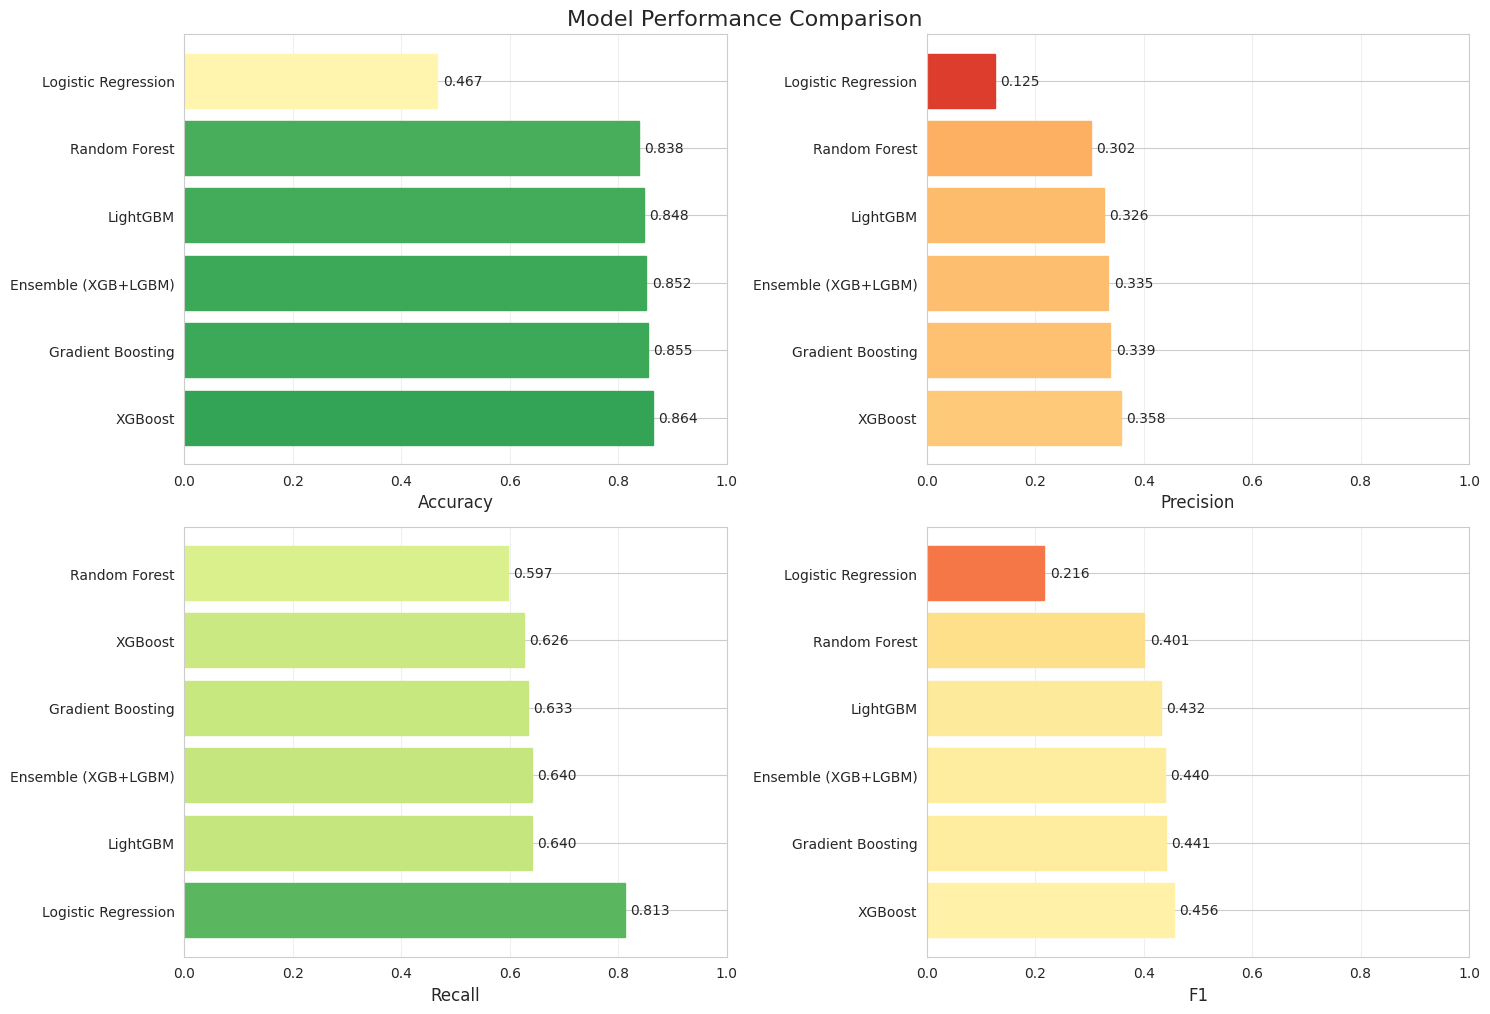

In [ ]:
# ===== VISUALIZE METRICS =====
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    data = results_df.sort_values(metric, ascending=False)
    bars = ax.barh(data['Model'], data[metric])

    colors = plt.cm.RdYlGn(data[metric])
    for bar, color in zip(bars, colors):
        bar.set_color(color)

    ax.set_xlabel(metric, fontsize=12)
    ax.set_xlim(0, 1)
    ax.grid(axis='x', alpha=0.3)

    for i, v in enumerate(data[metric]):
        ax.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.suptitle('Model Performance Comparison', fontsize=16, y=1.01)
plt.show()


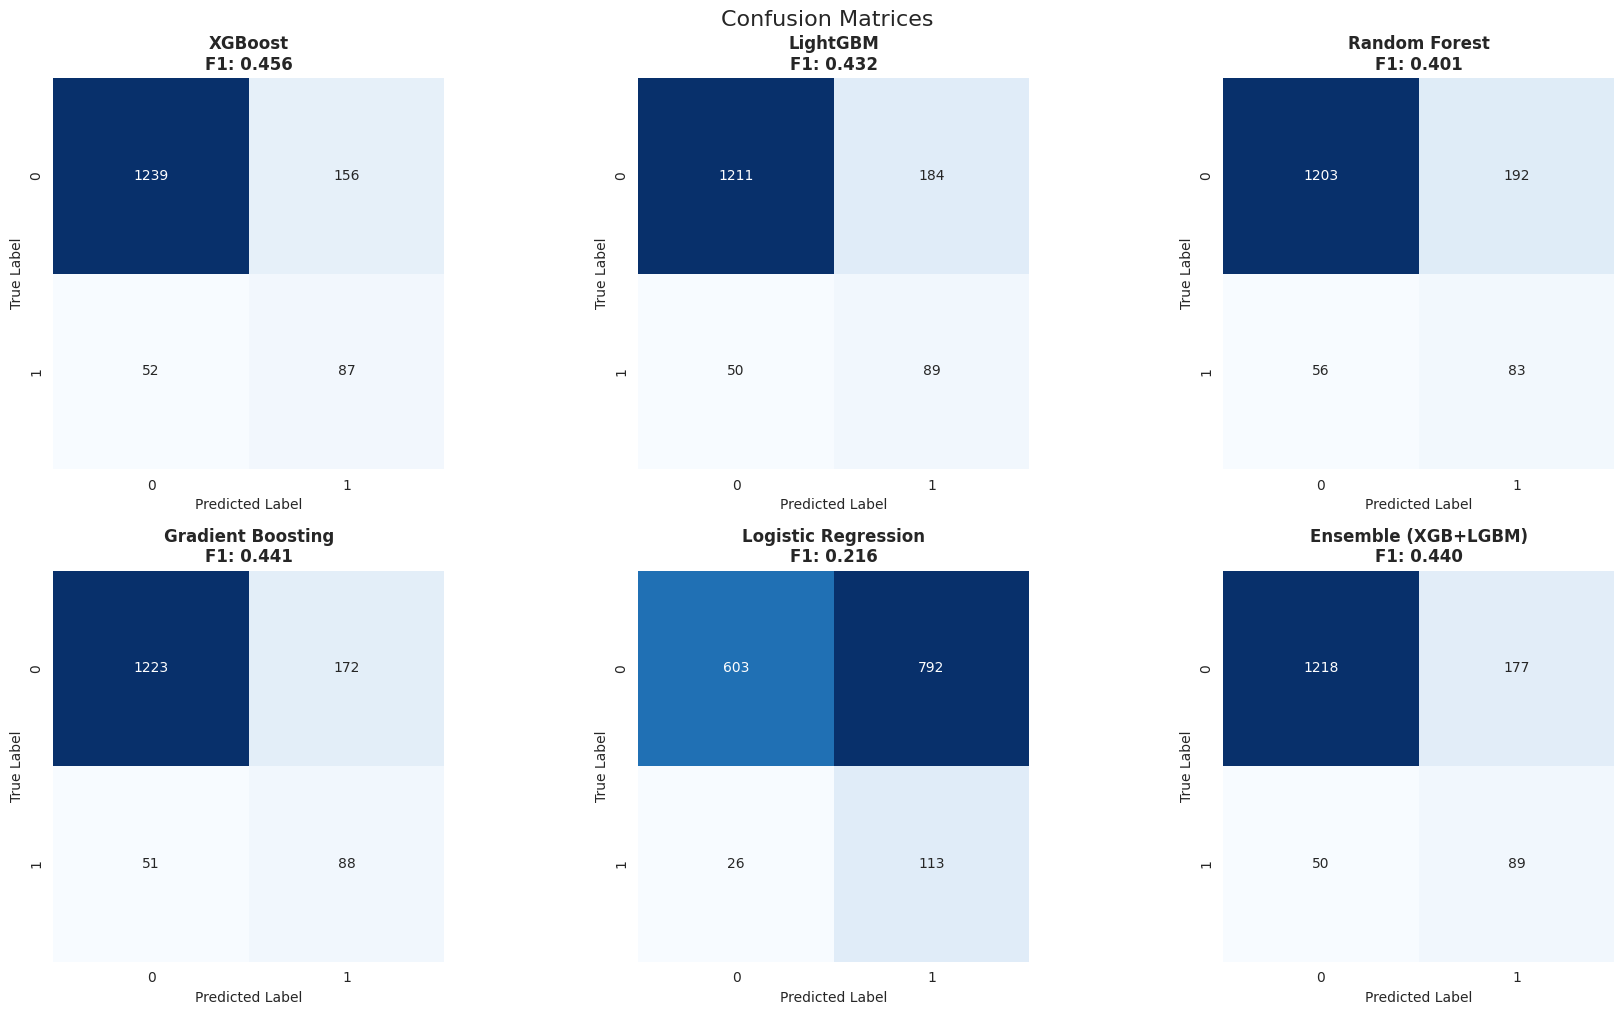

In [ ]:
# ===== CONFUSION MATRICES =====
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (name, y_pred) in enumerate(predictions.items()):
    cm = confusion_matrix(y_test, y_pred)
    ax = axes[idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False, square=True)
    f1 = results_df[results_df["Model"]==name]["F1"].values[0]
    ax.set_title(f'{name}\nF1: {f1:.3f}', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

if len(predictions) < 6:
    axes[-1].axis('off')

plt.tight_layout()
plt.suptitle('Confusion Matrices', fontsize=16, y=1.01)
plt.show()

### **Step 6: Advanced Visualizations & Final Recommendations**

In this section, we:
- **Plot ROC curves** to compare model discrimination ability
- **Plot Precision-Recall curves** (better for imbalanced data)
- **Analyze feature importance** to understand what drives predictions
- **Provide final model recommendations** based on different use cases

### ROC Curve (Receiver Operating Characteristic)
- Shows trade-off between **True Positive Rate** and **False Positive Rate**
- **AUC = 1.0** means perfect classifier
- **AUC = 0.5** means random guessing
- Good for comparing overall model quality

### Precision-Recall Curve
- Better than ROC for **imbalanced datasets** (which we have!)
- Shows trade-off between **precision** and **recall**
- Higher curve = better performance
- Baseline = proportion of positive class

### Feature Importance
- For tree-based models, shows which features matter most
- High importance = used frequently and early in decision trees
- Helps us understand **what signals predict emerging trends**

### Model Selection Guide

Choose your model based on your business priority:
- **High Recall** - Don't miss any emerging trends (catch everything, some false alarms OK)
- **High Precision** - Only flag confident predictions (fewer alerts, but more accurate)
- **Balanced (F1)** - Good all-around performance

---

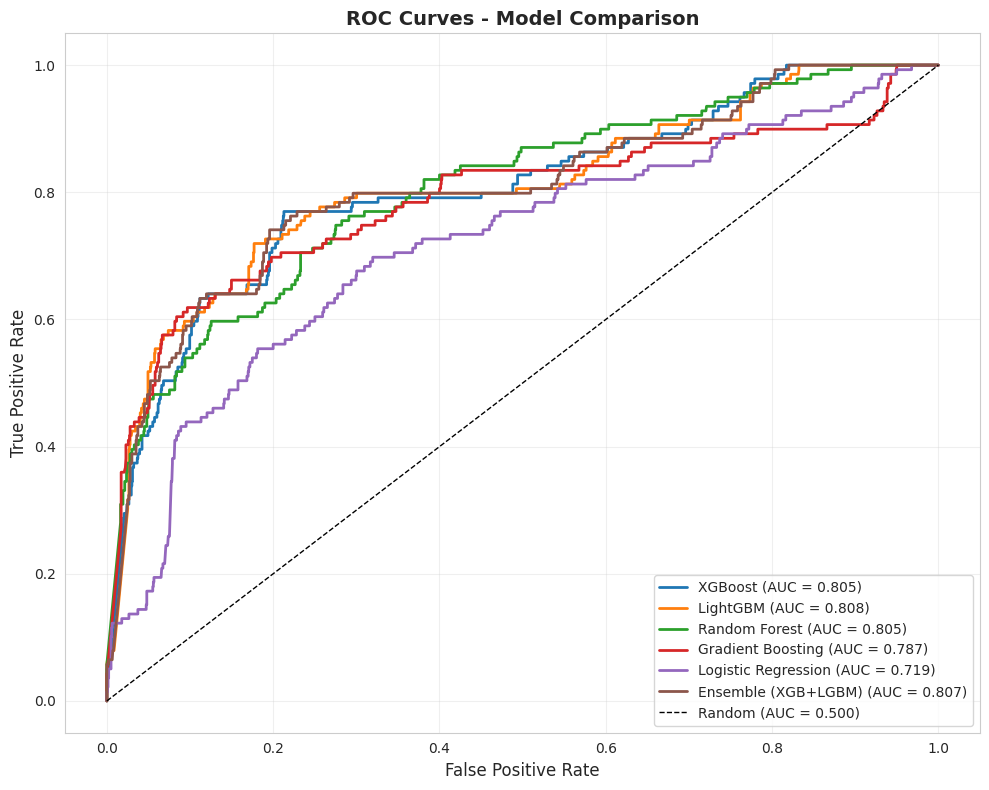

In [ ]:
# ===== ROC CURVES =====
plt.figure(figsize=(10, 8))

for name, y_prob in probabilities.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


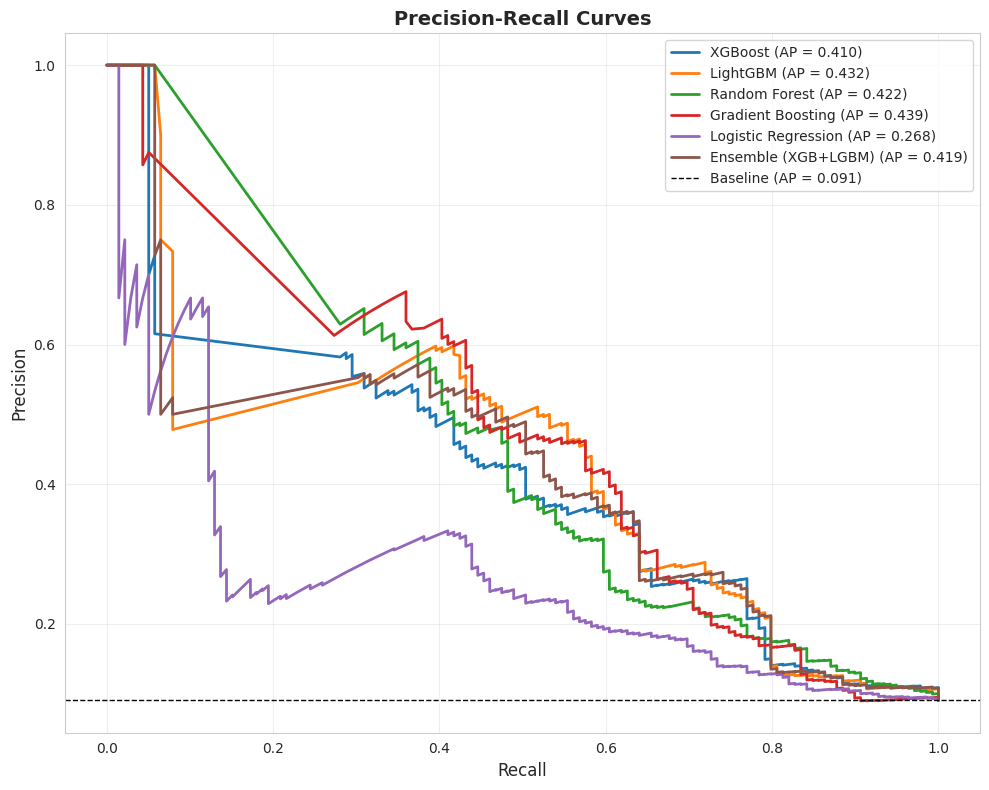

In [ ]:
# ===== PRECISION-RECALL CURVES =====
plt.figure(figsize=(10, 8))

for name, y_prob in probabilities.items():
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    ap = average_precision_score(y_test, y_prob)
    plt.plot(recall, precision, label=f'{name} (AP = {ap:.3f})', linewidth=2)

baseline = y_test.mean()
plt.axhline(y=baseline, color='k', linestyle='--',
            label=f'Baseline (AP = {baseline:.3f})', linewidth=1)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


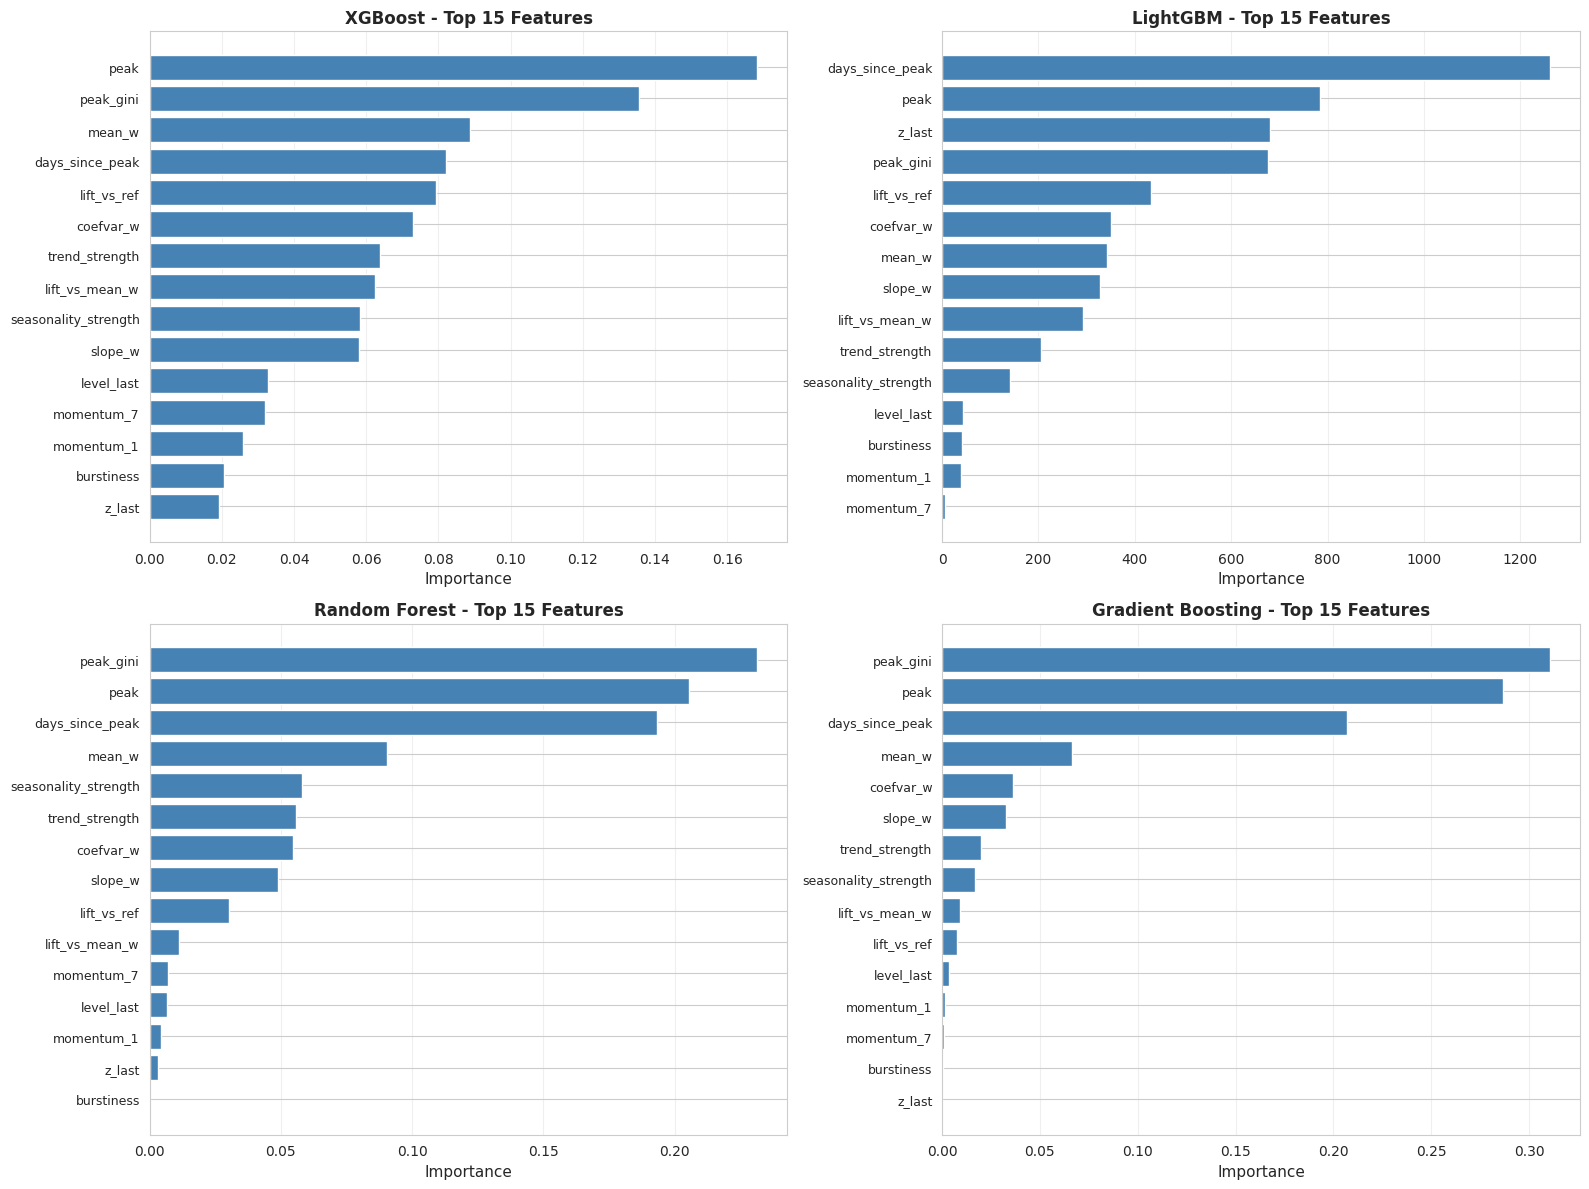

In [ ]:
# ===== FEATURE IMPORTANCE =====
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

tree_models = ['XGBoost', 'LightGBM', 'Random Forest', 'Gradient Boosting']
for idx, name in enumerate(tree_models):
    if name in trained_models:
        model = trained_models[name]
        importance = model.feature_importances_
        indices = np.argsort(importance)[-15:]

        ax = axes[idx]
        ax.barh(range(len(indices)), importance[indices], color='steelblue')
        ax.set_yticks(range(len(indices)))
        ax.set_yticklabels([feature_cols[i] for i in indices], fontsize=9)
        ax.set_xlabel('Importance', fontsize=11)
        ax.set_title(f'{name} - Top 15 Features', fontsize=12, fontweight='bold')
        ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# ===== RECOMMENDATIONS =====
print("\n" + "="*80)
print("MODEL RECOMMENDATIONS")
print("="*80)

best_f1_model = results_df.loc[results_df['F1'].idxmax()]
print(f"\n🏆 BEST OVERALL MODEL: {best_f1_model['Model']}")
print(f"   F1 Score: {best_f1_model['F1']:.4f}")
print(f"   ROC-AUC: {best_f1_model['ROC-AUC']:.4f}")
print(f"   Precision: {best_f1_model['Precision']:.4f}")
print(f"   Recall: {best_f1_model['Recall']:.4f}")
print("="*80)


MODEL RECOMMENDATIONS

🏆 BEST OVERALL MODEL: XGBoost
   F1 Score: 0.4555
   ROC-AUC: 0.8053
   Precision: 0.3580
   Recall: 0.6259


In [ ]:
# Keep a handle to the best model object for later use
best_model_name = best_f1_model["Model"]
best_model = trained_models[best_model_name]

print(f"\nUsing best model for live predictions: {best_model_name}")
print(f"Threshold used during evaluation: {THRESHOLD}")



Using best model for live predictions: XGBoost
Threshold used during evaluation: 0.35


## ~ Test Model Performance ~

In this section we test our best model on our prevously created **test dataset**, in addition we also fetch **real time pytrends data** and test against that as well.


In [ ]:
## Test XGBoost model on the TEST dataset

# 1. Generate predictions and probabilities for the test set (X_test)
y_pred_best = best_model.predict_proba(X_test)[:, 1]
y_class_best = (y_pred_best >= THRESHOLD).astype(int)

# 2. Add prediction results to the test dataframe for easy analysis
X_test_df = df[test_mask].copy()
X_test_df['predicted_prob'] = y_pred_best
X_test_df['predicted_class'] = y_class_best

# 3. Filter for predicted "emerging" trends (class 1)
emerging_predictions = X_test_df[X_test_df['predicted_class'] == 1]
print(f"Total rows in test set: {len(X_test_df)}")
print(f"Predicted EMERGING trends (class 1): {len(emerging_predictions)}")

# 4. Show the top 10 most confidently predicted emerging trends
print("\n--- Top 10 Predicted Emerging Trends ---")
print(emerging_predictions.sort_values('predicted_prob', ascending=False)[
    ['date', 'keyword', 'target', 'predicted_prob']
].head(10).to_string(index=False))

# 5. Show final metrics for the best model on the test set
# (This re-runs the metrics specific to the best model for final context)
from sklearn.metrics import classification_report
print("\n--- Classification Report (XGBoost) ---")
print(classification_report(y_test, y_class_best, digits=4, zero_division=0))

print(f"Final Test Metrics for {best_model_name} (Threshold={THRESHOLD}):")
tn, fp, fn, tp = confusion_matrix(y_test, y_class_best).ravel()
print(f"  True Positives (TP): {tp}")
print(f"  False Positives (FP): {fp}")
print(f"  False Negatives (FN): {fn}")
print(f"  True Negatives (TN): {tn}")
print("================================================================================\n")

Total rows in test set: 1534
Predicted EMERGING trends (class 1): 243

--- Top 10 Predicted Emerging Trends ---
      date       keyword  target  predicted_prob
2025-03-09 love triangle       1        0.978178
2025-03-02 love triangle       1        0.976158
2025-02-16 love triangle       1        0.972591
2025-02-23 love triangle       1        0.959330
2025-03-16 love triangle       1        0.957535
2025-03-23 love triangle       1        0.952008
2025-08-03 film festival       1        0.950531
2025-05-04 vampire movie       0        0.944627
2025-05-25 vampire movie       0        0.943113
2025-06-08 vampire movie       0        0.942344

--- Classification Report (XGBoost) ---
              precision    recall  f1-score   support

           0     0.9597    0.8882    0.9226      1395
           1     0.3580    0.6259    0.4555       139

    accuracy                         0.8644      1534
   macro avg     0.6589    0.7570    0.6890      1534
weighted avg     0.9052    0.8644   

In [ ]:
# Test XGBoost model on live Google Trends data

# Install and import pytrends for live Google Trends data
!pip -q install pytrends
from pytrends.request import TrendReq

def fetch_weekly_trends(keyword: str,
                        timeframe: str = "today 5-y",
                        geo: str = "") -> pd.Series:
    """
    Fetch weekly Google Trends interest_over_time() for a single keyword.
    Returns a Series indexed by date with 0–100 interest scores.
    """
    pytrends = TrendReq(hl='en-US', tz=360)
    pytrends.build_payload([keyword], timeframe=timeframe, geo=geo)
    df_trend = pytrends.interest_over_time()

    if df_trend is None or df_trend.empty:
        raise ValueError(f"No trend data for keyword: {keyword}")

    # Column name is the keyword itself
    series = df_trend[keyword].astype(float)

    # Ensure DateTimeIndex and resample to weekly averages
    series.index = pd.to_datetime(series.index)
    weekly = series.resample("W").mean()

    return weekly


In [ ]:
def predict_trend_for_keyword(keyword: str,
                              timeframe: str = "today 5-y",
                              geo: str = ""):
    """
    End-to-end:
    1. Fetch live Google Trends data.
    2. Engineer features to match training features.
    3. Apply same preprocessing (impute + scale).
    4. Use best_model to predict whether it is 'emerging'.
    """
    print(f"\n=== Live prediction for keyword: '{keyword}' ===")

    # 1) Fetch time series from Google Trends
    series = fetch_weekly_trends(keyword, timeframe=timeframe, geo=geo)
    print(f"Fetched {len(series)} weekly points from {series.index.min().date()} to {series.index.max().date()}")

    # 2) Build a 1-row feature DataFrame with same columns as training
    feat_row_raw = build_feature_row_for_keyword(
        series=series,
        feature_cols=feature_cols,
        train_df=train_df      # defined earlier: df[train_mask]
    )

    # 3) Apply SAME preprocessing (imputer + scaler)
    X_live = prepare_features(feat_row_raw)

    # 4) Predict probability and class using the best model
    prob_emerging = float(best_model.predict_proba(X_live)[0, 1])
    pred_class = int(prob_emerging >= THRESHOLD)

    label = "EMERGING" if pred_class == 1 else "STABLE"
    print(f"Predicted probability of 'emerging': {prob_emerging:.3f}")
    print(f"Using threshold {THRESHOLD:.2f} → classified as: {label}")

    return {
        "keyword": keyword,
        "prob_emerging": prob_emerging,
        "label": label
    }


In [ ]:
test_keywords = [
    "Stranger Things Season 5",
    "Ariana Grande",
    "Gladiator 2",
    "Avatar 4",
    "The Batman 2",
    "Superman Legacy",
    "Spider-Man Beyond the Spider-Verse",
    "Wicked",
    "Paddington in Peru",
    "Twisters",
]

live_results = []
for kw in test_keywords:
    try:
        res = predict_trend_for_keyword(kw, timeframe="today 5-y", geo="")
        live_results.append(res)
    except Exception as e:
        print(f"Error for '{kw}':", e)

pd.DataFrame(live_results)
pd.DataFrame(live_results).style.background_gradient(
    subset=["prob_emerging"], cmap="viridis"
)



=== Live prediction for keyword: 'Stranger Things Season 5' ===
Fetched 262 weekly points from 2020-11-22 to 2025-11-23
Predicted probability of 'emerging': 0.573
Using threshold 0.35 → classified as: EMERGING

=== Live prediction for keyword: 'Ariana Grande' ===
Fetched 262 weekly points from 2020-11-22 to 2025-11-23
Predicted probability of 'emerging': 0.120
Using threshold 0.35 → classified as: STABLE

=== Live prediction for keyword: 'Gladiator 2' ===
Fetched 262 weekly points from 2020-11-22 to 2025-11-23
Predicted probability of 'emerging': 0.115
Using threshold 0.35 → classified as: STABLE

=== Live prediction for keyword: 'Avatar 4' ===
Fetched 262 weekly points from 2020-11-22 to 2025-11-23
Predicted probability of 'emerging': 0.162
Using threshold 0.35 → classified as: STABLE

=== Live prediction for keyword: 'The Batman 2' ===
Fetched 262 weekly points from 2020-11-22 to 2025-11-23
Predicted probability of 'emerging': 0.138
Using threshold 0.35 → classified as: STABLE

=== 

,keyword,prob_emerging,label
0,Stranger Things Season 5,0.573065,EMERGING
1,Ariana Grande,0.120157,STABLE
2,Gladiator 2,0.114837,STABLE
3,Avatar 4,0.161635,STABLE
4,The Batman 2,0.138240,STABLE
5,Superman Legacy,0.209311,STABLE
6,Spider-Man Beyond the Spider-Verse,0.213473,STABLE
7,Wicked,0.604215,EMERGING
8,Paddington in Peru,0.159229,STABLE
9,Twisters,0.179962,STABLE
